In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Do Deeper Networks Solve the Problem?

If $\frac{|\lambda_{2}|}{|\lambda_{1}|}\approx{}1$, then the summand in $d_{Katz}$, $(\alpha{}A)^{k}\vec{1}$,  requires $k>>0$ before converging to the dominant eigenvector, $v_{1}$,

$$d_{Katz} = \sum_{k=0}^{n} (\alpha{}A)^{k}\vec{1} + \vec{v_{1}}\sum_{k=n+1}^{\infty}\alpha{}^{k}$$

at which point the second term can be computed without further powers of $A$. As such, we posit that deeper GCNs are required to learn the Katz Centrality of low-density, high eigenvalue-ratio SBMs. 

### Model and Dataset Code

SBMs are the same as Section 2.7.2, with $p\in{}[\frac{1}{50n},\frac{1}{n}]$. We still consider only the undirected, unweighted case.

In [2]:
torch.manual_seed(0)

num_graphs = 3000
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [3]:
# Compute the Mean Average Distance of inputs
def batched_MAD(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1).abs()
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

# Compute the Aggregation Norm
def batched_agg(X,edge_index,edge_weights,batch):
    nX = torch_scatter.scatter_sum(edge_weights[:,None] * X[edge_index[1]], edge_index[0],dim=0)
    X,nX = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch],\
              nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch]
    return torch.norm(X - nX,dim=1).mean()

# Compute normalized (absolute) rayleigh quotient
def rayleigh_quotient(X,edge_index,edge_weights,batch,eig_max,eig_min):
    num = torch_scatter.scatter_sum(X * torch_scatter.scatter_sum(edge_weights[:,None] * 
                                        X[edge_index[1]], edge_index[0],dim=0),
                                        batch, dim=0)
    denom = torch_scatter.scatter_sum(X**2,batch,dim=0)
    R = num/(denom)
    return torch.mean((eig_max[:,None] - R.abs())/(eig_max - eig_min)[:,None])

In [4]:
graph_results = []
model_mad = []
model_agg = []
model_rayleigh = []

for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    graph = GraphConv(1,32,1,k).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
    torch.save(graph.state_dict(),'base_{}'.format(k))
    torch.cuda.empty_cache()

    # Iterate through network layers and compute the MAD/Agg at each
    MAD,Agg,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        
        for jdx,m in enumerate(graph.intermediate):
            X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
            X = torch.nn.LeakyReLU()(graph.bn[jdx](X))
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            Agg[jdx] += batched_agg(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            Ray[jdx] += rayleigh_quotient(X,data.edge_index.cuda(),data.edge_weight.cuda(),
                                    batch,data.eig_max.cuda(),data.eig_min.cuda()).item()
        
    model_mad.append(MAD/(idx+1))
    model_agg.append(Agg/(idx+1))
    model_rayleigh.append(Ray/(idx+1))

### Results

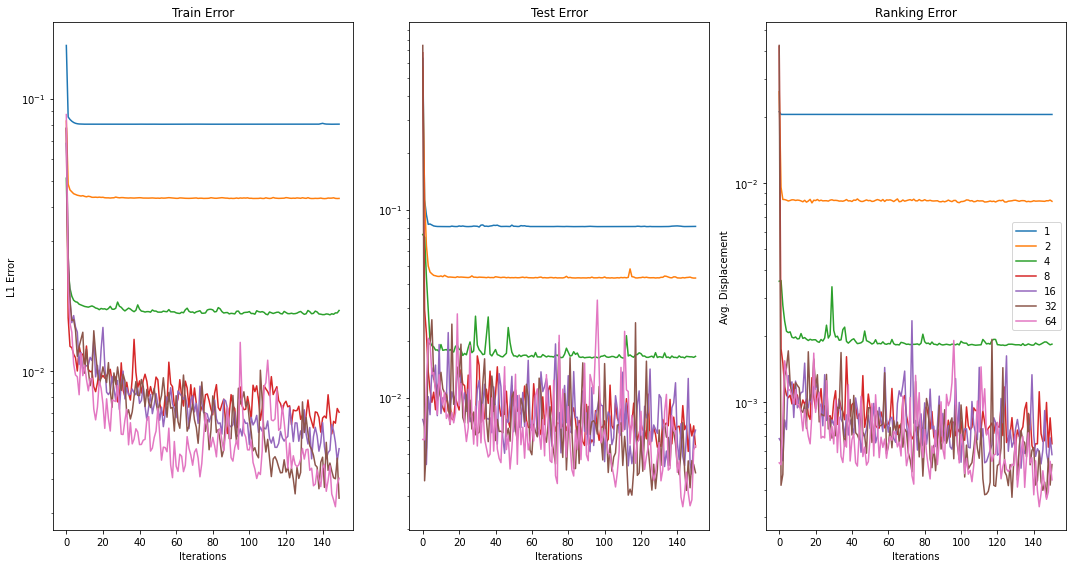

In [5]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for $l_{max}=1,2,4,...,64$. We also plot below the best values on the test loss versus number of trainable parameters. 

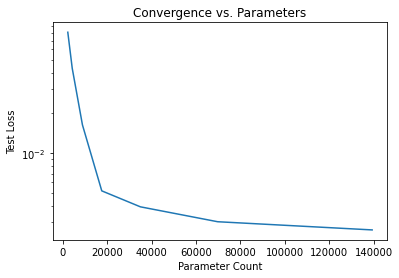

In [6]:
params = [2200,4200,8801,17505,34913,69729,139361]
plt.semilogy(params,[np.min(graph_results[i][1]) for i in range(7)])
plt.xlabel('Parameter Count')
plt.ylabel('Test Loss');
plt.title('Convergence vs. Parameters');

Increasing network depth leads to better performance; however, the minimum test loss stagnates past $l_{max}=8$ relative to parameter count, and it is still worse than for the initial $p\in{}[\frac{1}{n},\frac{10}{n}]$ dataset. Side note: the loss is already quite small for $l_{max}\geq{}16$ when the model is completely untrained; perhaps some sort of resevoir computing would work well?

### Some Analysis

We observe the minimum test loss increasing from $l_{max}=32$ to $l_{max}=64$. This suggests GraphConv is either a) starting to overfit due to the larger parameter count or b) having difficuilty backpropagating due to the greater model depth.

#### Is this Overfitting?

To assess the impact of parameter count, we propose a simple experiment. Like before, we train several GCNs while varying $l_{max}$; however, each is now followed by a variable-depth MLP, such that the total number of parameters is always constant and equal to that of the largest model. If overfitting is truly an issue, we should expect to see a) worse performance for all $l_{max}<32$ and b) more similar convergence for $l_{max}=32$ and $l_{max}=64$. 

In [7]:
class DoubleGraphConv(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(DoubleGraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.gcn = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.bn = torch.nn.ModuleList([torch_geometric.nn.BatchNorm(int_channels) for _ in range(depth)])
        
        self.mlp = torch.nn.ModuleList([torch.nn.Sequential(*[torch.nn.Linear(int_channels,int_channels),
                                                            torch.nn.BatchNorm1d(int_channels),
                                                            torch.nn.LeakyReLU(),
                                                            torch.nn.Linear(int_channels,int_channels)]) 
                                        for _ in range(depth)])
        self.final = torch.nn.Linear(int_channels,out_channels)
        
    def forward(self,X,edge_index,edge_weight,batch):
        X = self.start(X)
        
        for idx,m in enumerate(self.gcn):
            X = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(self.bn[idx](X))
            X = self.mlp[idx](X)
        
        return self.final(X)

In [8]:
internal_results = []

torch.manual_seed(0)
graph = DoubleGraphConv(1,32,1,32).cuda()

internal_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
torch.save(graph.state_dict(),'internal_{}'.format(32))
torch.cuda.empty_cache()

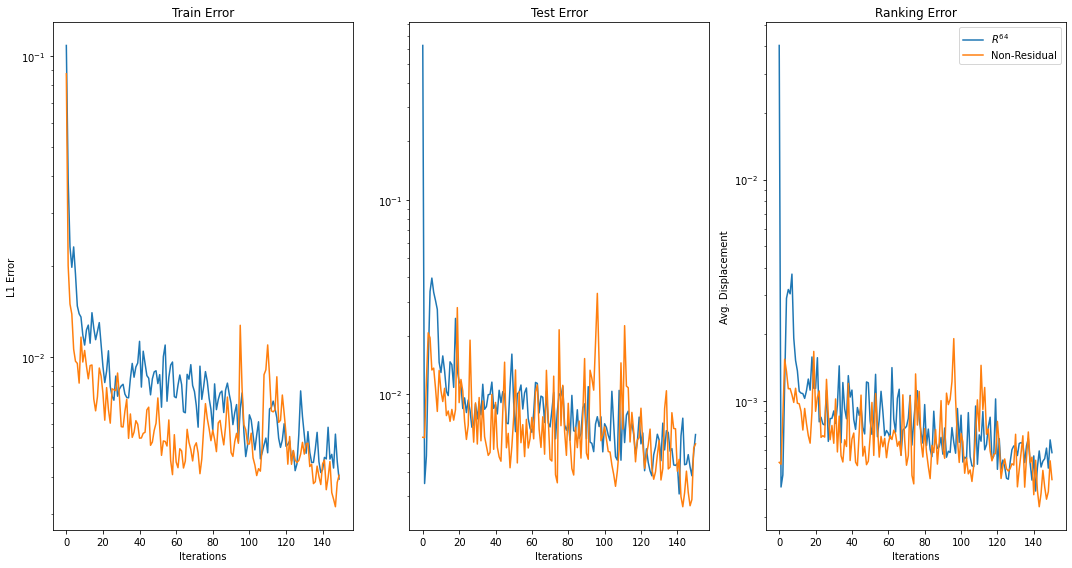

In [9]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(internal_results[0][0])
plt.semilogy(graph_results[-1][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(internal_results[0][1])
plt.semilogy(graph_results[-1][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(internal_results[0][2],label='$R^{64}$')
plt.semilogy(graph_results[-1][2],label='Non-Residual')

plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for $l_{max}=1,2,4,...,64$. We also plot below the best values on the test loss versus $l_{max}$. 

#### Adding Residual Connections

In [10]:
class ResidualGraphConv(torch.nn.Module):
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(ResidualGraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.bn = torch.nn.ModuleList([torch_geometric.nn.BatchNorm(int_channels) for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        # Run through GraphConv layers
        for idx,m in enumerate(self.intermediate):
            nX = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = X + torch.nn.LeakyReLU()(self.bn[idx](nX))
            
        # Project to out_channels
        return self.finish(X)

In [11]:
residual_results = []

torch.manual_seed(0)
graph = ResidualGraphConv(1,32,1,64).cuda()

residual_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
torch.save(graph.state_dict(),'residual_{}'.format(64))
torch.cuda.empty_cache()

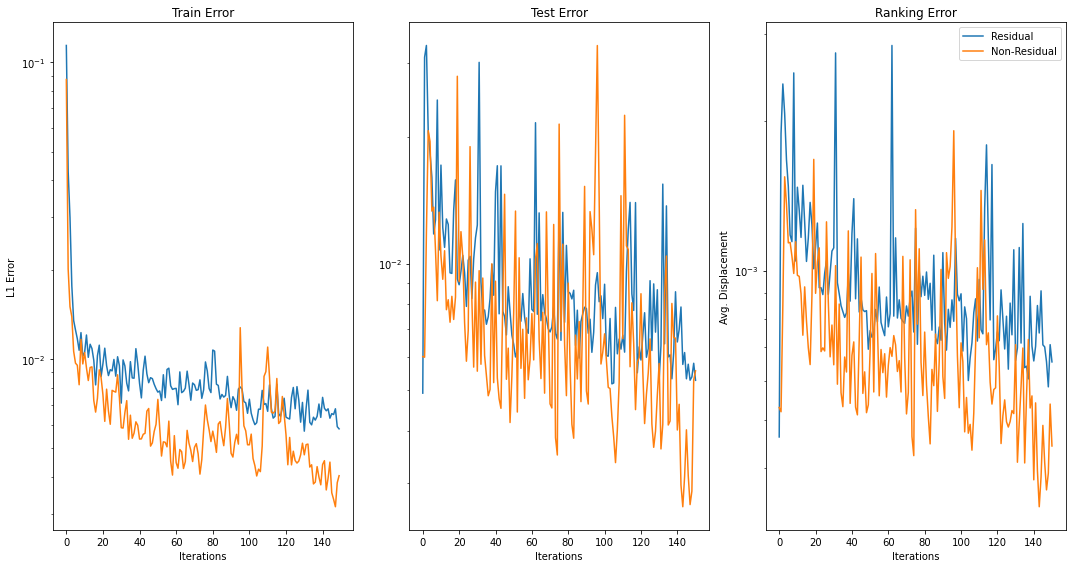

In [12]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(residual_results[0][0])
plt.semilogy(graph_results[-1][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(residual_results[0][1])
plt.semilogy(graph_results[-1][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(residual_results[0][2],label='Residual')
plt.semilogy(graph_results[-1][2],label='Non-Residual')

plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

#### Oversmoothing?

GCNs suffer from a peculiar phenomena known as *oversmoothing*. In essence,  performance tends to degrade as you add more layers, and the features of each node converge to similar values. We choose to measure smoothness by the sparsified Mean Average Distance [14],

$$\frac{1}{\sum_{i,j\in{}E}w_{ij}}\sum_{i,j\in{}E}w_{ij}(1 - \frac{|x_{j}^{T}x_{i}|}{||x_{i}||_{2}||x_{j}||_{2}})$$

Aggregation Norm (or AggNorm),

$$\frac{1}{|V|}\sum_{i\in{}V}||\frac{\sum_{j\in{}N_{i}^{1}}w_{ij}x_{j}}{||\sum_{j\in{}N_{i}^{1}}w_{ij}x_{j}||_{2}} - \frac{x_{i}}{||x_{i}||_{2}}||_{2}$$

and the absolute Rayleigh Quotient

$$\frac{1}{\lambda_{max}-\lambda_{min}}(\lambda_{max} - |\frac{\vec{x}A\vec{x}}{\vec{x}\cdot{}\vec{x}}|)$$

with MinMax normalization. AggNorm may be interpreted as a measure of how close the columns of $X^{l}$ are to eigenvectors of $A$. The normalized Rayleigh Quotient is even more specific, with low values indicating greater similarity to dominant eigenvector $v_{1}$. 

Current theoretical analysis of oversmoothing has been focused on the GCNConv operator of Kipf and Welling [15].

$$X^{l+1} = (\hat{D}^{\frac{-1}{2}}\hat{A}\hat{D}^{\frac{-1}{2}})X^{l}W$$
$$ \hat{A} = I + A \; \; \; \; \hat{D} = \hat{A}\vec{1}$$

This is a psuedo-spectral convolution, in it that aggregates using a form of the symmetric normalized graph Lapalcian $L_{sym} = I - D^{\frac{-1}{2}}AD^{\frac{-1}{2}}$. By definition, $L_{sym}$ possesses eigenvalues $0\leq{}\lambda_{i}\leq{}2$. We are  guaranteed an eigenvector $v_{i}=D^{\frac{1}{2}}\vec{1}$ for $i$ such that $\lambda_{i}=0$, and dropping $I$ shifts the eigenvalue spectra, making $v_{i}$ dominant. So therefore the asymptoptic behavior of our GCNConv aggregation step is to diffuse material until it is distributed according to the square root of the augmented node degree $\hat{D}$. [...]. However, the literatures demonstrates that spatial convolution algorithms, which do not explicitly incorporate $L_{sym}$, are no less vulnerable to oversmoothing [14,16]. 

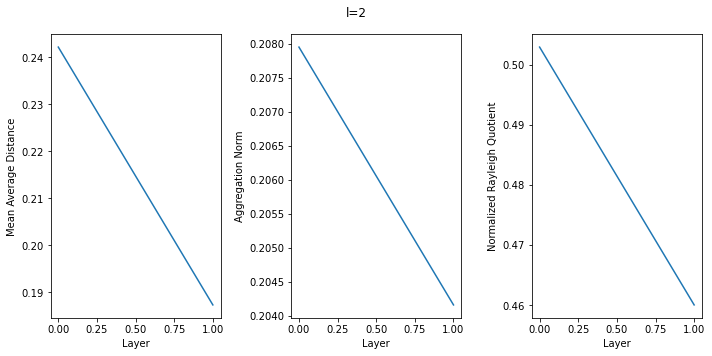

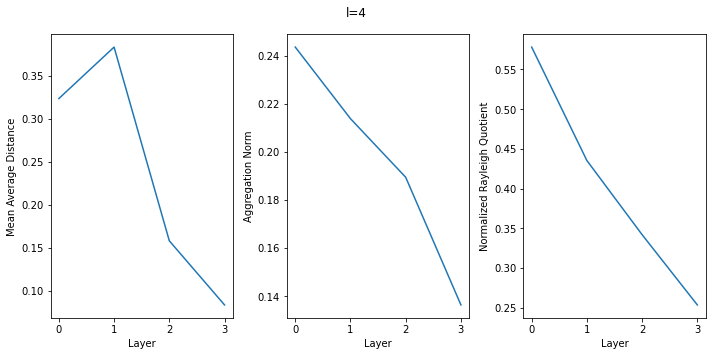

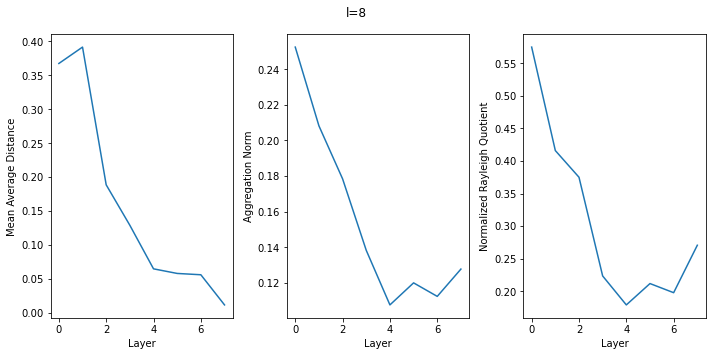

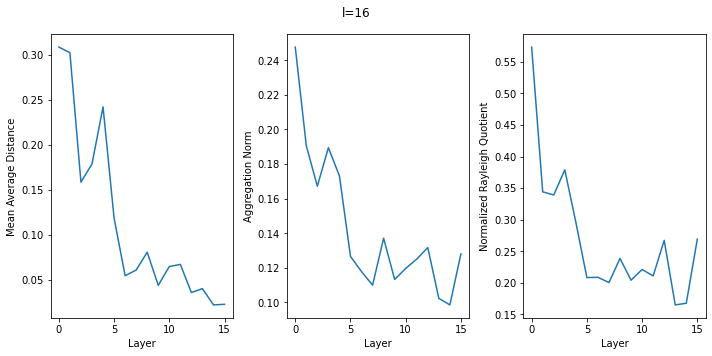

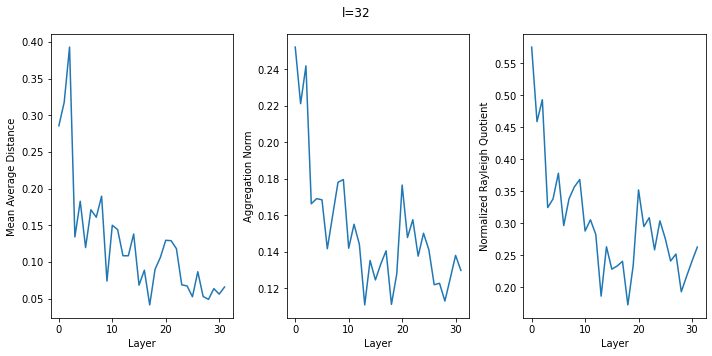

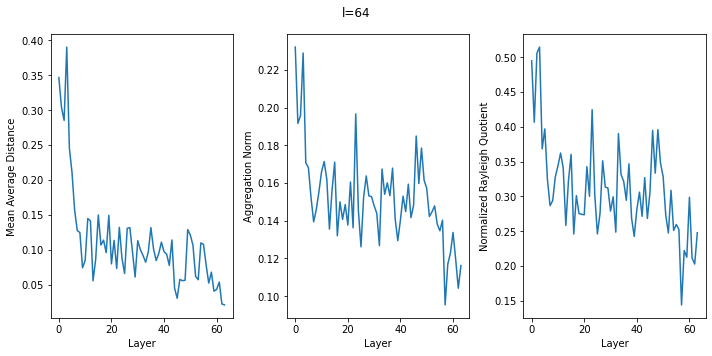

In [13]:
for idx,l in enumerate([2,4,8,16,32,64]):
  plt.figure(figsize=(10,5))

  plt.subplot(1,3,1)
  plt.plot(model_mad[idx+1],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(model_agg[idx+1])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(model_rayleigh[idx+1])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh Quotient')
    
  plt.suptitle("l={}".format(l))
  plt.tight_layout()
  plt.show()


In the above figure, we observe an initial decline in our smoothness metrics followed by oscillations in the deeper layers. MAD converges to approximately $0$ from $l_{max}=8$ onwards; however, both the AggNorm and Rayleigh Quotient remain relatively large. It seems that, while the model output is quite locally homogenous, it is still not all that close to $v_{1}$. And this is an issue. The relationship between $\vec{d}_{Katz}$ and $\vec{v}_{1}$ has been previously established; each GCN is clearly attempting to drive the normalized Rayleigh Coeff. down, and, indeed, the highest performing model (that for $l_{max}=32$) possesses the lowest Rayleigh in the final layer (but a higher MAD and comparable AggNorm).